# Predicting credit default with XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem **_

_NOTE: This notebook was created and tested using the `Python 3 (Data Science)` kernel._

---

---

## Contents

1. [Background](#Background)
1. [Preparation](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Extensions](#Extensions)

---

## Background

We will be using a dataset from the UCI Machine Learning Repository

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

The original dataset can be found here at the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients



## Install additional libraries

[Pandas profiling](https://github.com/pandas-profiling/pandas-profiling) works great for smaller datasets. Pandas profiling does not come preinstalled on the Data Science Kernel, but we can install it with pip.

In [204]:
!pip install pandas-profiling[notebook]

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## Preparation

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [237]:
import boto3
import re
import sagemaker # Amazon SageMaker's Python SDK provides many helper functions

session = sagemaker.Session()

bucket = session.default_bucket()
prefix = 'sagemaker/credit-xgboost'
 
# Define IAM role
role = sagemaker.get_execution_role()

In [206]:
(bucket,prefix,role)

('sagemaker-eu-west-1-641758013508',
 'sagemaker/credit-xgboost',
 'arn:aws:iam::641758013508:role/service-role/AmazonSageMaker-ExecutionRole-20201031T094356')

Now let's bring in the Python libraries that we'll use throughout the analysis

In [207]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker.deserializers                    # Converts strings for HTTP POST requests on inference

---

## Data

The dataset should already be available in the repository under the dataset folder. Now lets read this into a Pandas data frame and take a look.


In [208]:
data = pd.read_csv('./dataset/UCI_Credit_Card.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


Let's talk about the data.  At a high level, we can see:

* We have 30000 user and their credits records
* 25 features per record
* The features are numeric
* The data is not sorted

_**Specifics on each of the features:**_

*Features:*
* `ID`: ID of user
* `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* `SEX`: Gender (1=male, 2=female)
* `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* `Marriage`: Marital status (1=married, 2=single, 3=other)
* `AGE`: Age in years
* `PAY_0`: Repayment status for this month. (-2=No consumption, -1=paid duly, 0=use of revolving credit, 1=payment delayed 1 month, 2=payment delayed 2 months, [...], 9=payment delayed 9 months or more)
* `PAY_2`: Repayment status for last month. (same as above)
* `PAY_3`: Repayment status for 2 months ago. (same as above)
* `PAY_4`: Repayment status for 3 months ago. (same as above)
* `PAY_5`: Repayment status for 4 months ago. (same as above)
* `PAY_6`: Repayment status for 5 months ago. (same as above)
* `BILL_AMT1`: Amount of bill this month.
* `BILL_AMT2`: Amount of bill last month.
* `BILL_AMT3`: Amount of bill 2 months ago.
* `BILL_AMT4`: Amount of bill 3 months ago.
* `BILL_AMT5`: Amount of bill 4 months ago.
* `BILL_AMT6`: Amount of bill 5 months ago.
* `PAY_AMT1`: Amount of payment made this month.
* `PAY_AMT2`: Amount of payment made last month.
* `PAY_AMT3`: Amount of payment made 2 months ago.
* `PAY_AMT4`: Amount of payment made 3 months ago.
* `PAY_AMT5`: Amount of payment made 4 months ago.
* `PAY_AMT6`: Amount of payment made 5 months ago.

*Target variable:*
* `default.payment.next.month`: Default payment next month (1=yes, 0=no).



### Data Exploration
Let's start exploring the data.  First, let's understand how the features are distributed.

In [209]:
from pandas_profiling import ProfileReport

#profile_data = data
#profile = ProfileReport(profile_data, title="Credit card default data set report")
#profile

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

### First Training (Local)

Let's first train a simple decision tree model to train on our data. Our target variable is 'default.payment.next.month'. We will start with a tree depth of 10. We split our data into a training dataset consisting of 80% of the samples, and a test dataset with 20% of the samples. We also drop the ID column as it's a simple record identifier with no predictive value

In [211]:
#importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['ID','default.payment.next.month'], axis=1), data.filter(like='default.payment.next.month'), test_size=0.20, random_state=42)

classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
classifier.fit(X_train, y_train)

# test data set accuracy
predictions = classifier.predict(X_test)
print("Test set accuracy: {}".format(accuracy_score(y_true = y_test, y_pred = predictions)))

# train data set accuracy (to measure overfitting)
predictions = classifier.predict(X_train)
print("Train set accuracy: {}".format(accuracy_score(y_true = y_train, y_pred = predictions)))

Test set accuracy: 0.812
Train set accuracy: 0.8465416666666666


We can see that our accuracy with our test dataset is around 81% and with our train dataset is around 84% meaning we are not overfitting to the training data.

What would happen if we would use a tree depth of 100?

In [212]:
classifier = DecisionTreeClassifier(max_depth=100, random_state=14) 
classifier.fit(X_train, y_train)

# test data set accuracy
predictions = classifier.predict(X_test)
print("Test set accuracy: {}".format(accuracy_score(y_true = y_test, y_pred = predictions)))

# train data set accuracy (to measure overfitting)
predictions = classifier.predict(X_train)
print("Train set accuracy: {}".format(accuracy_score(y_true = y_train, y_pred = predictions)))

Test set accuracy: 0.7231666666666666
Train set accuracy: 0.9994583333333333


Clearly now there is overfitting to the training data going on, with our model giving much better results on the data with which we trained than with data not seen before (test data)

### Data Feature Engineering

Let's try to do some feature engineering and improve on the previous model accuracy.

**Drop meaningless features**

ID is used as a record identified and is not useful from a model training or prediction point of view

In [213]:
data = data.drop(['ID'], axis=1)


Education of type 4, 5 and 6 are unknown, so let's combine them.

In [214]:
# Education 4,5,6 are unknown, so set to 0
data.loc[data['EDUCATION'] > 3 , 'EDUCATION'] = 4
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


#### Remove scientific notation
Some of the features contains numerical values in scientific notation, i.e 5*10e5. Format those values to numerical values

In [215]:
# Calculates and deformats scientific notation, ie (5*10^5).
def remove_scientific_notation(value):
    if (type(value) == str) and ('^+' in value):
        new = value.replace('^+', 'e')
        sep = new.split('×')
        return int(sep[0])*int(float(sep[1]))
    return value
        
columns_to_deformat =  ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for colmn in columns_to_deformat:
    data[colmn] = data[colmn].apply(remove_scientific_notation)
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


### MinMax scaler to numerical features
Scale the numerical features using a MinMax scaler


In [216]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

columns_to_scale = ['AGE', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

data[columns_to_scale] = min_max_scaler.fit_transform(data[columns_to_scale])

data


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,0.010101,2,2,1,0.051724,2,2,-1,-1,-2,-2,0.149982,0.069164,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,1
1,0.111111,2,2,2,0.086207,-1,2,0,0,0,2,0.148892,0.067858,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1
2,0.080808,2,2,2,0.224138,0,0,0,0,0,0,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
3,0.040404,2,2,1,0.275862,0,0,0,0,0,0,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
4,0.040404,1,2,1,0.620690,-1,0,-1,0,0,0,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,1,3,1,0.310345,0,0,0,0,0,0,0.313716,0.249208,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892,0
29996,0.141414,1,3,2,0.379310,-1,-1,-1,-1,0,0,0.148008,0.067955,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000,0
29997,0.020202,1,2,2,0.275862,4,3,2,-1,0,0,0.149674,0.069405,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864,1
29998,0.070707,1,3,1,0.344828,1,-1,0,0,0,-1,0.145064,0.140604,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412,1


#### One-hot encode categorical values

The Sex, Education and Marriage features are categorical with no inherent meaning to the ordering, which is why we one-hot encode them.



In [218]:
columns_to_onehot_encode = ['SEX', 'EDUCATION', 'MARRIAGE']

model_data = pd.get_dummies(data, prefix=columns_to_onehot_encode, columns=columns_to_onehot_encode)

model_data

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,0.010101,0.051724,0.149982,0.069164,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.111111,0.086207,0.148892,0.067858,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.080808,0.224138,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.040404,0.275862,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.040404,0.620690,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.310345,0.313716,0.249208,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29996,0.141414,0.379310,0.148008,0.067955,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29997,0.020202,0.275862,0.149674,0.069405,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29998,0.070707,0.344828,0.145064,0.140604,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Move target column to front. 
SageMaker assumes first column is the target column.

In [219]:
model_data = model_data[ ['default.payment.next.month'] + [ col for col in model_data.columns if col != 'default.payment.next.month' ] ]

### Split data

In [220]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10% 

Upload train and validation data to S3


In [221]:
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')


Fetch xgboost container

In [222]:
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='latest')

#### Create input channels
SageMaker work with the concept of channels. Here, we create a training and validation input channles to be used when training


In [223]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')


#### Train the model
To train the model, we
* initiate a SageMaker session,
* create an estimator object and specify training configuration,
* set the hyperparameters,
* call the fit method, passing in the training and validation channels

In [224]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=200)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-05-06 13:17:21 Starting - Starting the training job...
2021-05-06 13:17:45 Starting - Launching requested ML instancesProfilerReport-1620307041: InProgress
......
2021-05-06 13:18:45 Starting - Preparing the instances for training......
2021-05-06 13:19:45 Downloading - Downloading input data...
2021-05-06 13:20:12 Training - Downloading the training image..Arguments: train
[2021-05-06:13:20:33:INFO] Running standalone xgboost training.
[2021-05-06:13:20:33:INFO] File size need to be processed in the node: 10.7mb. Available memory size in the node: 8390.34mb
[2021-05-06:13:20:33:INFO] Determined delimiter of CSV input is ','
[13:20:33] S3DistributionType set as FullyReplicated
[13:20:33] 21000x89 matrix with 1869000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-06:13:20:33:INFO] Determined delimiter of CSV input is ','
[13:20:33] S3DistributionType set as FullyReplicated
[13:20:33] 6000x89 matrix with 534000 entries loaded from /opt/ml

### Deploy model

In [225]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

-------------!

Specify how to serialize incoming data

In [226]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer() 

Throw some test data at the endpoint

In [227]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['default.payment.next.month'], axis=1).to_numpy())

Compute some metrics to evaluate model

In [ ]:
from sklearn.metrics import average_precision_score, accuracy_score

average_precision = average_precision_score(test_data['default.payment.next.month'], np.round(predictions))
average_accuracy = accuracy_score(test_data['default.payment.next.month'], np.round(predictions))

print('Precision: ', np.round(average_precision, 3))
print('Accuracy: ', np.round(average_accuracy, 3))

print('\nConfusion matrix:')
pd.crosstab(index=test_data['default.payment.next.month'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

Create ROC graph

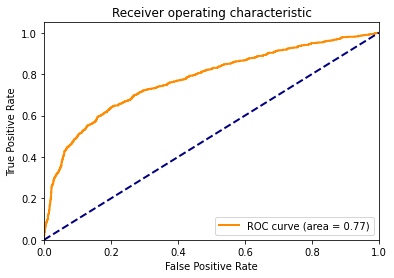

In [238]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_data['default.payment.next.month'], predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Clean up!
When you're done, don't forget to tear down the endpoint.

In [232]:
xgb_predictor.delete_endpoint()